# Pre processing data

In [1]:
#!pip install pandas
import pandas as pd
import csv

#### Changing the delimiter from ',' to ';'

In [2]:
with open('data.csv', 'r') as input_file, open('data_all.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter=';')
    for line in input_file:
        line = line.strip()
        
        last_comma = line.rfind(',')

        if last_comma != -1:
            row = [line[:last_comma], line[last_comma + 1:]]
            
        writer.writerow(row)

#### Importing the data

In [3]:
data_all = pd.read_csv('data_all.csv', sep=';')
data_all.describe()

,ticket_description,expert_id
count,400,400
unique,40,10
top,Les permissions des rôles d'utilisateur ne fon...,expert_8
freq,16,53


#### Normalizing characters (because of invalid characters in french data)

In [4]:
import unicodedata

def normalize_chars(text):
    if isinstance(text, str):
        normalized = unicodedata.normalize('NFKD', text)
        no_diacritics = ''.join(char for char in normalized if not unicodedata.combining(char))
        return no_diacritics
    return text

data_all['ticket_description'] = data_all['ticket_description'].apply(normalize_chars)

data_all.to_csv('data_all_normalized.csv', sep=';', index=False)

#### Check for null values

In [5]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ticket_description  400 non-null    object
 1   expert_id           400 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


#### Check validity of values

In [6]:
import re

def check_row(row):
    c1 = len(row['ticket_description'].strip()) > 0
    c2 = bool(re.match(r'^expert_\d+$', row['expert_id']))
    return c1 and c2

data_all_cleaned = data_all[data_all.apply(check_row, axis=1)]

data_all = data_all_cleaned.reset_index(drop=True)

data_all.describe()

,ticket_description,expert_id
count,400,400
unique,40,10
top,Les permissions des roles d'utilisateur ne fon...,expert_8
freq,16,53


#### Change the label type from string to integer (out of simplicity, since expert ids are integers)

In [7]:
for i,row in data_all.iterrows():
    data_all.at[i, 'expert_id'] = int(data_all.at[i, 'expert_id'].split('_')[1])
data_all.head()

,ticket_description,expert_id
0,Data not syncing with the cloud.,6
1,System reports inaccurate metrics.,4
2,Payment gateway timeout error.,5
3,Permissions issue for user roles.,0
4,Integration with third-party API fails.,5


#### Splitting the data into english and french parts

In [8]:
num_eng = 200

data_eng = data_all.iloc[:num_eng]
data_fr = data_all.iloc[num_eng:]

data_eng.to_csv('data_1_eng.csv', sep=';', index=False)
data_fr.to_csv('data_1_fr.csv', sep=';', index=False)

#### Analyzing the distribution

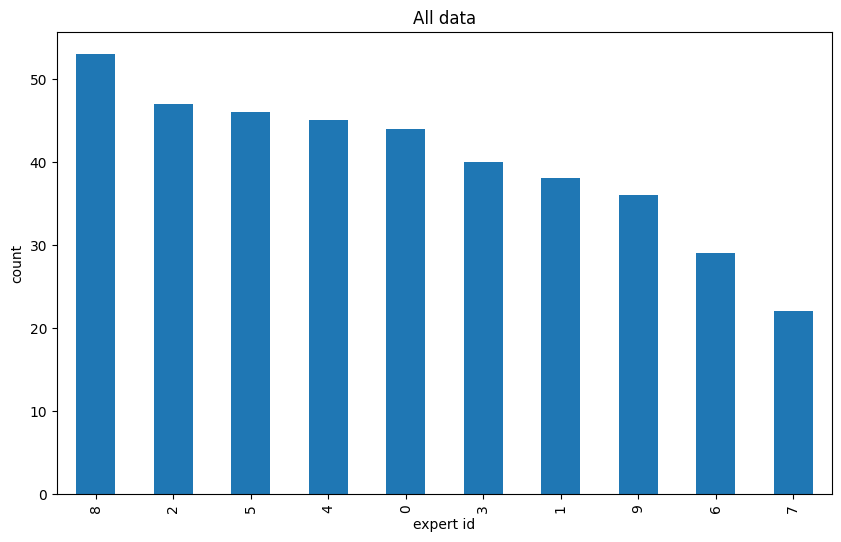

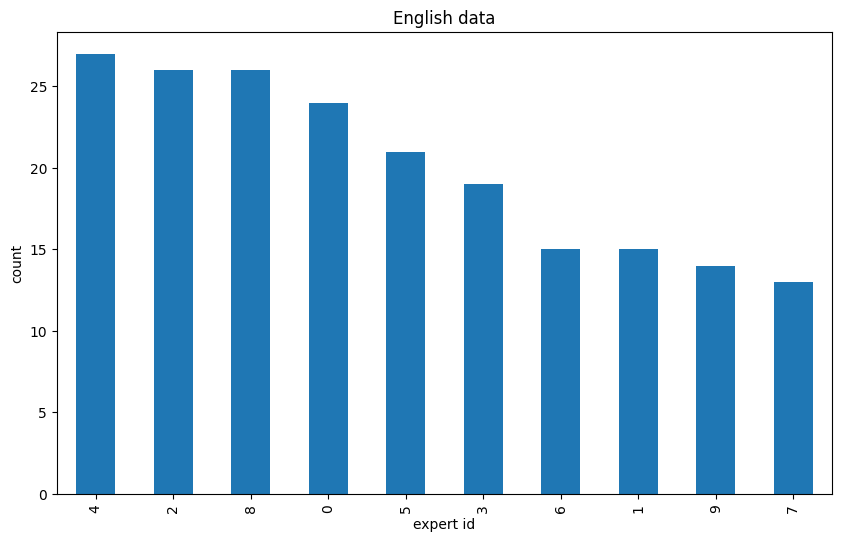

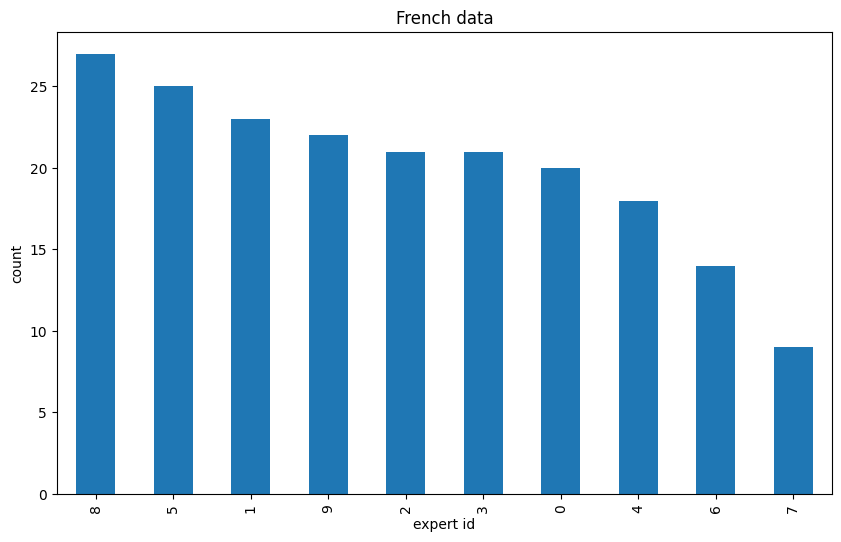

In [9]:
#!pip install matplotlib
import matplotlib.pyplot as plt

distributions = [
    (data_all['expert_id'].value_counts(), 'All data'),
    (data_eng['expert_id'].value_counts(), 'English data'),
    (data_fr['expert_id'].value_counts(), 'French data')
]

for dist, title in distributions:
    dist.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.xlabel('expert id')
    plt.ylabel('count')
    plt.show()

#### There is a significance difference in distribution between the highest and the lowest frequent classes, but overall, the data is not highly imbalanced

#### APPROACH 1: Removing the duplicates

##### In the first approach, this task was concidered to be a multi-class classification problem where each sentance belongs to only one label. Therefore, the duplicates represent redundant data which can influence overfitting and that's why we remove it

In [10]:
data_1_all = data_all.drop_duplicates()
data_1_eng = data_eng.drop_duplicates()
data_1_fr = data_fr.drop_duplicates()
print(data_1_all.describe())
print(data_1_eng.describe())
print(data_1_fr.describe())

                                       ticket_description  expert_id
count                                                 250        250
unique                                                 40         10
top     Le planificateur n'execute pas les taches prog...          0
freq                                                    9         30
                         ticket_description  expert_id
count                                   124        124
unique                                   20         10
top     Application fails to save settings.          0
freq                                      8         16
                                       ticket_description  expert_id
count                                                 126        126
unique                                                 20         10
top     Le systeme genere des metriques inexactes dans...          8
freq                                                    9         16


#### APPROACH 2: Soft label encoding

##### In the second approach, this task is concidered to be a multi-label classification problem, where sentances do not belong to exclusively one class. Sentances can be completed by different experts and all of the provided data is useful. Instead of having multiple sentances with single labels, we group the sentances and assign labels of the all experts that were assigned to each sentance. This is label encoding, but instead of it being binary, we use soft labels where values are not 1s and 0s, but are actually float values in range [0,1], indicating the frequency of assigned experts

In [11]:
def encode_labels(data):
    result_rows = []
    
    # iterating through unique sentances
    for ticket_description in data['ticket_description'].unique():
        # filtering rows
        filtered_rows = data[data['ticket_description'] == ticket_description]
        
        # calculating the expert frequency
        frequency = filtered_rows['expert_id'].value_counts(normalize=True).reindex(range(num_classes), fill_value=0)
        expert_ids_str = ','.join(map(lambda x: f"{x:.3f}", frequency.values))
        
        # appending the results
        result_rows.append({
            'ticket_description': ticket_description,
            'expert_ids': expert_ids_str
        })
    
    return pd.DataFrame(result_rows)

num_classes = data_all['expert_id'].nunique()

data_2_all = encode_labels(data_all)
data_2_eng = encode_labels(data_eng)
data_2_fr = encode_labels(data_fr)

data_2_eng.to_csv('data_2_all.csv', sep=';', index=False)
data_2_eng.to_csv('data_2_eng.csv', sep=';', index=False)
data_2_fr.to_csv('data_2_fr.csv', sep=';', index=False)

# First model: Traditional vectorization with Naive Bayes and Logistic Legression

#### The traditional model was initially done with the first approach: multi-class classification, while the second advanced model was done also with the second apporach of multi-label classification

#### Data splitting

##### Since the first approach is mutli-class classification, we will perform the classical splitting of data into train, valid and test sets. Since we do not have a lot of data and we would like to evaluate all of the classes (experts), we will make sure to have at least one instance of each class in all three data splits. Since input data is not large, we will manually make sure to have the right ratio of splits (we cannot count on creating splits by comparing ratios to a random number)

In [12]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

def assign_train_valid_test_split(df, class_column, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1, random_seed=None):
    # checking the sum of all ratios
    assert (train_ratio + valid_ratio + test_ratio) == 1.0

    # creating dataframes for splits
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # iterating through all the classes and grouping rows
    for class_label, group in df.groupby(class_column):
        # shuffling the group
        group = group.sample(frac=1, random_state=random_seed).reset_index(drop=True)

        # calculating the sizes
        train_size = int(len(group) * train_ratio)
        valid_size = int(len(group) * valid_ratio)

        # make sure to have at least one instance in each split
        train_size = max(train_size, 1)
        valid_size = max(valid_size, 1)
        test_size = max(len(group) - train_size - valid_size, 1)

        # adjust sizes
        while train_size + valid_size + test_size > len(group):
            if train_size > valid_size and train_size > test_size:
                train_size -= 1
            elif valid_size > test_size:
                valid_size -= 1
            else:
                test_size -= 1

        # splitting the group
        train_split = group[:train_size]
        valid_split = group[train_size:train_size + valid_size]
        test_split = group[train_size + valid_size:]

        # appending the data
        train_data = pd.concat([train_data, train_split], ignore_index=True)
        valid_data = pd.concat([valid_data, valid_split], ignore_index=True)
        test_data = pd.concat([test_data, test_split], ignore_index=True)

    # shuffling final splits
    train_data = train_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    valid_data = valid_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    test_data = test_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # adding a split column
    train_data['split'] = 'train'
    valid_data['split'] = 'valid'
    test_data['split'] = 'test'

    # combine all splits into a single dataframe for simplicity
    final_df = pd.concat([train_data, valid_data, test_data], ignore_index=True)

    return final_df

data_all = assign_train_valid_test_split(data_all, random_seed=1, class_column='expert_id')
data_eng = assign_train_valid_test_split(data_eng, random_seed=1, class_column='expert_id')
data_fr = assign_train_valid_test_split(data_fr, random_seed=1, class_column='expert_id')

##### Inspecting to make sure the ratios are approapriate

In [13]:
print(data_all.value_counts('split', normalize=True))
print(data_eng.value_counts('split', normalize=True))
print(data_fr.value_counts('split', normalize=True))

split
train    0.7900
test     0.1225
valid    0.0875
Name: proportion, dtype: float64
split
train    0.780
test     0.145
valid    0.075
Name: proportion, dtype: float64
split
train    0.780
test     0.135
valid    0.085
Name: proportion, dtype: float64


##### Making sure all of the classes are present in all three splits

In [14]:
print(len(data_eng[data_eng['split']=='train'].expert_id.unique()))
print(len(data_eng[data_eng['split']=='valid'].expert_id.unique()))
print(len(data_eng[data_eng['split']=='test'].expert_id.unique()))

print(len(data_all[data_all['split']=='train'].expert_id.unique()))
print(len(data_all[data_all['split']=='valid'].expert_id.unique()))
print(len(data_all[data_all['split']=='test'].expert_id.unique()))

10
10
10
10
10
10


##### In the second approach, since the sentances are grouped and unique, if we split the data into training, valid and test sets, a significant part of the data would not used in the training and therefore not learned on, which we want to avoid since we do not have a lot of data. Instead of splitting, we will use nested k fold cross validation to make sure we use all of the unique data during training and evaluating the model

#### Vectorizing

In [15]:
#!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

##### Since the chosen models Naive Bayes and Logistic Regression require numerical features, we use a simple and effiicent TF-IDF vectorization to convert sentances into numbers, by measuering words importance in sentances and their uniquenes across all sentances  

In [16]:
def get_tfidf_vectors_and_labels(df, vectorizer, split="train", include_valid=False):
    # in case we want to use valid split for training or testing
    if include_valid:
        combined_data = df[df.split.isin([split, "valid"])]
    else:
        combined_data = df[df.split == split]
    # fitting the vectorizer
    if split == "train":
        vectorizer.fit(combined_data['ticket_description'])
    # transforming sentances into numbers
    vectors = vectorizer.transform(combined_data['ticket_description'])
    # attaching the labels
    labels = combined_data['expert_id']
    
    return vectors.toarray(), labels.to_numpy(dtype=int), vectorizer

#### Training

##### The training and predicting is performed with either Naive Bayes or Logistic Regression. The models are similar in complexity, where Naive Bayes chooses the class based on probabilites of words belonging to that class, while logistci regression learns the words contributions to sentance's class

In [17]:
from sklearn.metrics import f1_score, classification_report

def do_tfidf_prediction(df, max_features, model='Naive Bayes'):
    # initializing vectorizer with given number of features
    vectorizer = TfidfVectorizer(max_features=max_features)
    # getting the numerical transformations
    # here, because of model's simplicity and small data, we will include valid split into training
    vectors_train, labels_train, vectorizer = get_tfidf_vectors_and_labels(df, split="train", vectorizer=vectorizer, include_valid=True)
    vectors_test, labels_test, _ = get_tfidf_vectors_and_labels(df, split="test", vectorizer=vectorizer)
    
    # training naive bayes or logistic regression model
    if model == 'Naive Bayes':
        classifier = MultinomialNB().fit(vectors_train, labels_train)
    else:
        classifier = LogisticRegression().fit(vectors_train, labels_train)
    
    # predictions
    predicted_train = classifier.predict(vectors_train)
    predicted_test = classifier.predict(vectors_test)
    
    # overall f1 scores, macro since classes are not exactly evenly distributed
    f1_train = f1_score(labels_train, predicted_train, average='macro')
    f1_test = f1_score(labels_test, predicted_test, average='macro')
    
    return f1_train, f1_test, vectorizer, classifier


##### Inspecting results for a fixed size of max_features

In [18]:
f1_train, f1_test, _, _ = do_tfidf_prediction(data_all, max_features = 10)
f1_train, f1_test

(0.11772011123907462, 0.03305322128851541)

#### Evaluating

##### Trying out different number of max_features and plotting their train and test f1 scores. It's performed with both models on three different datasets: english only, french only and all combined

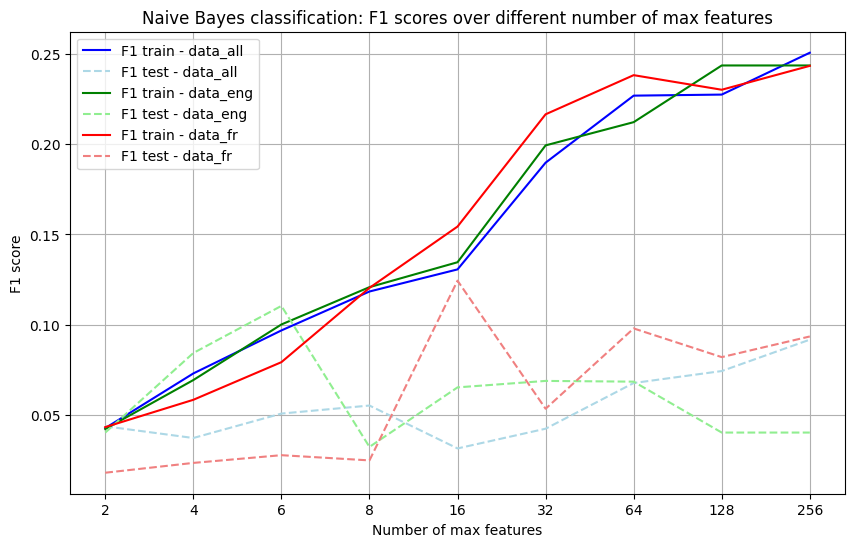

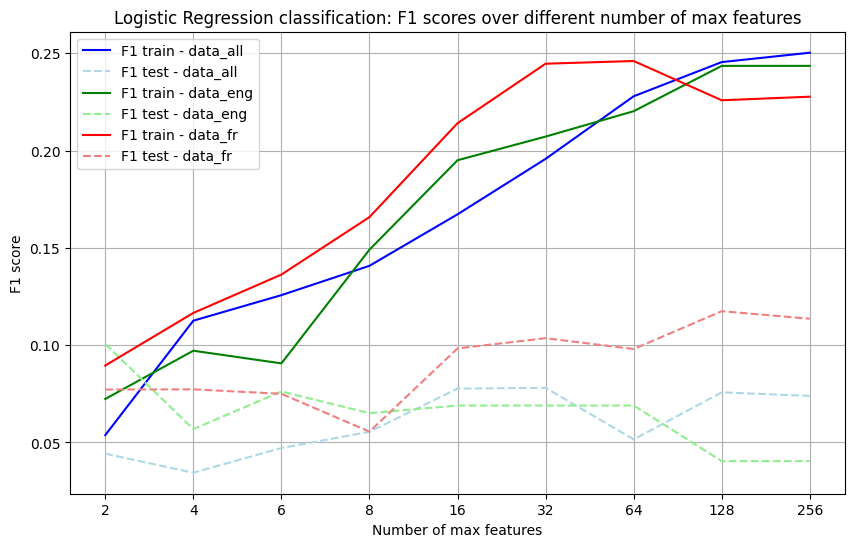

In [19]:
datasets = {
    "data_all": data_all,
    "data_eng": data_eng,
    "data_fr": data_fr
}

# setting different colours for datasets
colors = {
    "data_all": ("blue", "lightblue"),
    "data_eng": ("green", "lightgreen"),
    "data_fr": ("red", "lightcoral")
}

max_features_list = [2, 4, 6, 8, 16, 32, 64, 128, 256]

models = ['Naive Bayes', 'Logistic Regression']

for model_name in models:

    plt.figure(figsize=(10, 6))
    
    # iterating through datasets
    for dataset_name, dataset in datasets.items():
        
        f1_scores_train = []
        f1_scores_test = []
        
        # calculating the f1 scores
        for max_features in max_features_list:
            f1_train, f1_test, _, _ = do_tfidf_prediction(dataset, max_features=max_features, model=model_name)
            f1_scores_train.append(f1_train)
            f1_scores_test.append(f1_test)
        
        # plotting train and test scores
        plt.plot(
            np.arange(len(max_features_list)),
            f1_scores_train,
            label=f"F1 train - {dataset_name}",
            color=colors[dataset_name][0]
        )
        plt.plot(
            np.arange(len(max_features_list)),
            f1_scores_test,
            label=f"F1 test - {dataset_name}",
            color=colors[dataset_name][1],
            linestyle="dashed"
        )
    
    plt.xticks(np.arange(len(max_features_list)), max_features_list)
    plt.xlabel("Number of max features")
    plt.ylabel("F1 score")
    plt.title(f"{model_name} classification: F1 scores over different number of max features")
    plt.legend()
    plt.grid(True)
    
    plt.show()

#### Inference

##### Since the goal of this task is to return top three experts for a sentence in inference, we will convert the predictions into probabilites and return top three of them

In [20]:
def inference(classifier, input_sentence, vectorizer, k=3):
    # vectorizing the input sentance
    input_vector = vectorizer.transform([input_sentence]).toarray()

    # predicting probabilities for all calsses
    if hasattr(classifier, "predict_proba"):
        probs = classifier.predict_proba(input_vector).squeeze()
    else:
        raise ValueError("The provided classifier does not support probability prediction.")
    
    # getting top k predictions
    top_k_indices = np.argsort(probs)[-k:][::-1]
    top_k_classes = [f"class_{i}" for i in top_k_indices]
    top_k_probs = probs[top_k_indices]

    return top_k_classes, top_k_probs

##### Passing a new sentance to the Naive Bayes model with both english and french data, and 256 max features

In [21]:
_, _, vectorizer, classifier = do_tfidf_prediction(data_all, max_features = 256, model='Naive Bayes')

inference(classifier, 'Memory limit exceeded.', vectorizer, k=3)

(['class_5', 'class_0', 'class_6'],
 array([0.1311454 , 0.1305303 , 0.12289652]))

### Conclusion: The multi-class classification approach, where same sentances are assigned different classes, definitely affects the performanse. On top of that, the data set is too small to produce high quality results, specially after removing the duplicates. The large number of classes is also making it harder to learn patterns. The limited data size leads to overfitting on the training set, and poor generalization on the test set. The results are generally poor and similar for all three datasets.

# Second model: BERT

#### BERT is one of the most popular large language models, famous for its fine tuned usages, amongst which is classification of text. For this task, we are using a pret trained version of BERT, called DistilBERT. This model is smaller in size and faster, and is suitable for the small dataset we are using.

#### This model is used for both approaches: multi-class classification, and the multi-label classification, with slightly different cofigurations. Here we are focusing on two different subsets: the english only data and the combined both languages data

##### For the first approach, we split the data into train, valid and test sets, while the second approach will use nested k fold cross validation

In [22]:
x_train_all = data_all[data_all.split=='train']['ticket_description'].values
y_train_all = data_all[data_all.split=='train']['expert_id'].values
x_valid_all = data_all[data_all.split=='valid']['ticket_description'].values
y_valid_all = data_all[data_all.split=='valid']['expert_id'].values
x_test_all = data_all[data_all.split=='test']['ticket_description'].values
y_test_all = data_all[data_all.split=='test']['expert_id'].values


x_train_eng = data_eng[data_eng.split=='train']['ticket_description'].values
y_train_eng = data_eng[data_eng.split=='train']['expert_id'].values
x_valid_eng = data_eng[data_eng.split=='valid']['ticket_description'].values
y_valid_eng = data_eng[data_eng.split=='valid']['expert_id'].values
x_test_eng = data_eng[data_eng.split=='test']['ticket_description'].values
y_test_eng = data_eng[data_eng.split=='test']['expert_id'].values

### Tokenizer

##### Since BERT is a tranformer architecture, it requires the input text to be tokenized. Here we are introducing two different tokenizers, one for english data and the other one for multilingual, becasue of the presence of french language. MAX_LEN is calculated in order to use less than default 512 tokens, for efficiency, since the sentances in our data are much small than that.

In [23]:
#!pip install transformersa
from transformers import DistilBertTokenizer

MAX_LEN = 0

tokenizer_eng = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', padding=True, truncation=True)
tokenizer_all = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased', padding=True, truncation=True)

# combining all data to find the max tokens size
all_data = np.concatenate((x_train_all, x_valid_all, x_test_all))

# calculating the max tokens length and inspecting the tokenizer output
for i in range(len(all_data)):
    if len(tokenizer_eng(all_data[i])['input_ids']) > MAX_LEN:
        MAX_LEN = len(tokenizer_eng(all_data[i])['input_ids'])
    if i == 0:
        # tokenize sentences
        tokenizer_out = tokenizer_eng(all_data[i])
        # convert numerical tokens to alphabetical tokens
        encoded_tok = tokenizer_eng.convert_ids_to_tokens(tokenizer_out.input_ids)
        # decode tokens back to string
        decoded = tokenizer_eng.decode(tokenizer_out.input_ids)
        print(tokenizer_out)
        print('\n')
        print(encoded_tok, '\n')
        print('\n')
        print(decoded, '\n')
        print('\n')
        print('---------------- \n')

# multiplied by 2, to allow twice longter sentances in inference
MAX_LEN = MAX_LEN * 2
MAX_LEN

C:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'input_ids': [101, 2543, 9628, 5991, 4646, 4026, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


['[CLS]', 'fire', '##wall', 'blocks', 'application', 'traffic', '.', '[SEP]'] 



[CLS] firewall blocks application traffic. [SEP] 



---------------- 



72

### Custom dataset

##### Creating a custom dataset class which will be used by other tools during training and evaluating

In [24]:
#!pip3 install torch torchvision torchaudio
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len, soft_labels=False):
        self.sentences = sentences
        # Can be either hard or soft labels
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.soft_labels = soft_labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        # returns sentance and its label(s)
        sentence = str(self.sentences[item])
        label = self.labels[item]

        # tokenize the sentence
        tokenizer_out = self.tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        # handle soft labels for second approach
        if self.soft_labels:
            # convert the soft labels into right format
            label_tensor = torch.tensor(
                list(map(float, label.split(','))), dtype=torch.float
            )
        else:
            # convert the hard labels
            label_tensor = torch.tensor(label, dtype=torch.long)

        # return a dictionary of outputs
        return {
            'input_ids': tokenizer_out['input_ids'].flatten(),
            'attention_mask': tokenizer_out['attention_mask'].flatten(),
            'label': label_tensor
        }


# for first approach
train_dataset_all = MyDataset(x_train_all, y_train_all, tokenizer_all, MAX_LEN)
valid_dataset_all = MyDataset(x_valid_all, y_valid_all, tokenizer_all, MAX_LEN)
test_dataset_all = MyDataset(x_test_all, y_test_all, tokenizer_all, MAX_LEN)

train_dataset_eng = MyDataset(x_train_eng, y_train_eng, tokenizer_eng, MAX_LEN)
valid_dataset_eng = MyDataset(x_valid_eng, y_valid_eng, tokenizer_eng, MAX_LEN)
test_dataset_eng = MyDataset(x_test_eng, y_test_eng, tokenizer_eng, MAX_LEN)

# for second approach
dataset_2_all = MyDataset(
    data_2_all['ticket_description'].values,
    data_2_all['expert_ids'].values,
    tokenizer_all,
    MAX_LEN,
    soft_labels=True
)
dataset_2_eng = MyDataset(
    data_2_eng['ticket_description'].values,
    data_2_eng['expert_ids'].values,
    tokenizer_eng,
    MAX_LEN,
    soft_labels=True
)

##### Inspect the output shape of the dataset

In [25]:
train_dataset_all[0]

{'input_ids': tensor([  101, 16011, 33743, 47352, 19800, 26482,   119,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'label': tensor(4)}

### Building the model

##### Importing the models

In [26]:
from transformers import DistilBertModel

PRE_TRAINED_MODEL_NAME_ENG = 'distilbert-base-uncased'
PRE_TRAINED_MODEL_NAME_ALL = 'distilbert-base-multilingual-cased'


distil_bert_eng = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME_ENG)
distil_bert_all = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME_ALL)
print(distil_bert_eng)
print(distil_bert_all)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

##### Inspecting output and shape of the model

In [27]:
first_sample = train_dataset_eng[0]
hidden_state = distil_bert_eng(first_sample['input_ids'].unsqueeze(0), attention_mask=first_sample['attention_mask'].unsqueeze(0))
hidden_state[0].shape

torch.Size([1, 72, 768])

#### Building the classifier

##### The pretrained BERT model is used as a parent class for our custom class which represents the fine tuned model. In order to perform classifications, we need to create an output layer which will continue on the output of the parent model encoder. We put a simple linear layer which acts as a classifier, by transforming the dimensions of the encoder's output to the number of unique classes in this task. These outputs are raw logits and are later transformed into probabilities when calculating the losses. Dropout of 10% is used on the encoder's output for regularization. The loss functions differ for the two approaches. The soft labeled approach is using KL Divergence Loss, whcih is comparing the probability distributions of true and predicted labels, while the first approach is using Cross Entropy Loss on the predicted hard labels of the batch and the true ones. The encoder output we are using here is contained in the 0th token, which represents the special CLS token in the transformer architecture and it contains information such as the sentiment of the sentance

In [33]:
from transformers import DistilBertPreTrainedModel, DistilBertConfig

# used for freezing the model parameters during fine tuning
FREEZE_PRETRAINED_MODEL = True

class DistilBertForSentimentClassification(DistilBertPreTrainedModel):
    def __init__(self, pretrained_model_name, config, num_labels, freeze_encoder=False, soft_labels=False):
        super().__init__(config)
        self.num_labels = num_labels
        self.soft_labels = soft_labels
        # iload a pretrained DistilBERT model as encoder
        self.encoder = DistilBertModel.from_pretrained(pretrained_model_name)
        # freeze the parameters
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        # classifier layer
        self.classifier = torch.nn.Linear(
            in_features=config.dim, out_features=self.num_labels, bias=True
        )
        # usage of small dropout for regularization
        self.dropout = torch.nn.Dropout(p=0.1)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        # encoding a batch of sequences
        encoder_output = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )
        # extract the hidden state from the output
        hidden_state = encoder_output[0] # (bs, seq_len, dim)
        # only select the encoding corresponding to the first token (CLS)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        # apply dropout
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        # feed into the classifier
        logits = self.classifier(pooled_output)  # (bs, num_labels)

        outputs = (logits,) + encoder_output[1:]

        # compute loss
        if labels is not None:
            if self.soft_labels:
                # use KLDivLoss for soft labels
                loss_function = torch.nn.KLDivLoss(reduction="batchmean")
                logits = torch.nn.functional.log_softmax(logits, dim=-1)
                loss = loss_function(logits, labels)
            else:
                # use CrossEntropyLoss for hard labels
                loss_function = torch.nn.CrossEntropyLoss()
                loss = loss_function(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)



classes = data_all.expert_id.unique().tolist()

# create the models

# first approach
model_eng_only = DistilBertForSentimentClassification(
    pretrained_model_name=PRE_TRAINED_MODEL_NAME_ENG,
    config=distil_bert_eng.config,
    num_labels=len(classes),
    freeze_encoder = FREEZE_PRETRAINED_MODEL
    )

model_all = DistilBertForSentimentClassification(
    pretrained_model_name=PRE_TRAINED_MODEL_NAME_ALL,
    config=distil_bert_all.config,
    num_labels=len(classes),
    freeze_encoder = FREEZE_PRETRAINED_MODEL
)

# for approach 2
model_2_eng_only = DistilBertForSentimentClassification(
    pretrained_model_name=PRE_TRAINED_MODEL_NAME_ENG,
    config=distil_bert_eng.config,
    num_labels=len(classes),
    freeze_encoder=FREEZE_PRETRAINED_MODEL,
    soft_labels=True
)

model_2_all = DistilBertForSentimentClassification(
    pretrained_model_name=PRE_TRAINED_MODEL_NAME_ALL,
    config=distil_bert_all.config,
    num_labels=len(classes),
    freeze_encoder=FREEZE_PRETRAINED_MODEL,
    soft_labels=True
)


##### Choosing the device for training

In [34]:
if torch.cuda.is_available():
    print('GPU will be used.')
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print('CPU will be used.')

CPU will be used.


### Training and evaluation

#### First approach

##### We are using the Trainer class to handle the training of the model. We are initializing it for both datasets: english only and combined. Parameters such as learning rate, batch size, number of epochs and weight decay are defined here. Also, the binary evaluation metrics: accuracy, precision, recall and f1 are also passed to the Trainer class for evaluation.

In [35]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist()
    }

training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    logging_first_step=True,
    logging_steps=20,
    num_train_epochs=16,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    learning_rate=5e-6,
    weight_decay=0.01
)

trainer_eng_only = Trainer(
    model=model_eng_only,
    args=training_args,
    train_dataset=train_dataset_eng,
    eval_dataset=valid_dataset_eng,
    compute_metrics=compute_metrics
)
trainer_all = Trainer(
    model=model_all,
    args=training_args,
    train_dataset=train_dataset_all,
    eval_dataset=valid_dataset_all,
    compute_metrics=compute_metrics
)

##### Execution of training

In [36]:
trainer_eng_only.train()
trainer_all.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.349600,2.353878,0.066667,"[0.0, 0.0, 0.0, 0.18181818181818182, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,2.342600,2.352216,0.066667,"[0.0, 0.0, 0.0, 0.15384615384615385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,2.339800,2.350731,0.066667,"[0.0, 0.0, 0.0, 0.18181818181818182, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,2.338200,2.349469,0.066667,"[0.0, 0.0, 0.0, 0.15384615384615385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,2.333300,2.348430,0.066667,"[0.0, 0.0, 0.0, 0.15384615384615385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,2.338200,2.347440,0.066667,"[0.0, 0.0, 0.0, 0.15384615384615385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,2.333800,2.346493,0.066667,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.07692307692307693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,2.332600,2.345683,0.066667,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.07692307692307693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,2.323000,2.344975,0.066667,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.07692307692307693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
10,2.330000,2.344339,0.066667,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.07692307692307693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.332500,2.305150,0.057143,"[0.0, 0.0, 0.0, 0.15384615384615385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,2.327100,2.303114,0.057143,"[0.0, 0.0, 0.0, 0.15384615384615385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,2.326500,2.301356,0.057143,"[0.0, 0.0, 0.0, 0.15384615384615385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,2.312700,2.299524,0.085714,"[0.0, 0.0, 0.0, 0.21428571428571427, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,2.321400,2.298137,0.085714,"[0.0, 0.0, 0.0, 0.21428571428571427, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,2.308500,2.296700,0.085714,"[0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.11538461538461539, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,2.310500,2.295418,0.114286,"[0.2, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.16666666666666666, 0.0, 0.0, 0.13043478260869565, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.25, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,2.309700,2.294528,0.114286,"[0.2, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.16666666666666666, 0.0, 0.0, 0.13043478260869565, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.25, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,2.304100,2.293555,0.114286,"[0.2, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.16666666666666666, 0.0, 0.0, 0.13043478260869565, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.25, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
10,2.291200,2.292721,0.114286,"[0.2, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.16666666666666666, 0.0, 0.0, 0.13043478260869565, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.25, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


TrainOutput(global_step=640, training_loss=2.3105577319860457, metrics={'train_runtime': 115.8205, 'train_samples_per_second': 43.654, 'train_steps_per_second': 5.526, 'total_flos': 92907791271936.0, 'train_loss': 2.3105577319860457, 'epoch': 16.0})

##### Plotting of the training and validation losses

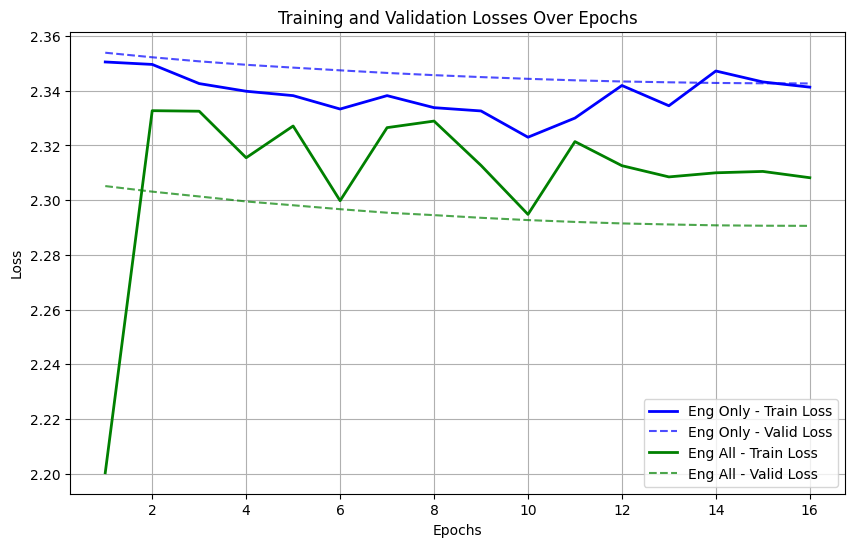

In [37]:
def plot_losses(trainers, labels, colors):
    plt.figure(figsize=(10, 6))

    for trainer, label, color in zip(trainers, labels, colors):
        # extract the log history
        log_history = trainer.state.log_history

        # filter train losses
        train_losses = [
            entry['loss'] for entry in log_history 
            if 'loss' in entry and 'epoch' in entry
        ]
        # filter valid losses
        eval_losses = [
            entry['eval_loss'] for entry in log_history 
            if 'eval_loss' in entry
        ]

        # make sure the lengths match
        min_length = min(len(train_losses), len(eval_losses))
        train_losses = train_losses[:min_length]
        eval_losses = eval_losses[:min_length]

        # x axis for epochs
        epochs = range(1, min_length + 1)

        plt.plot(epochs, train_losses, label=f"{label} - Train Loss", color=color, linewidth=2)
        plt.plot(epochs, eval_losses, label=f"{label} - Valid Loss", color=color, linestyle='dashed', alpha=0.7)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_losses(
    trainers=[trainer_eng_only, trainer_all],
    labels=["Eng Only", "Eng All", "All"],
    colors=["blue", "green", "red"]
)

#### Evaluation

##### Predicting the labels for the test set

In [38]:
test_results_eng_only = trainer_eng_only.predict(test_dataset=test_dataset_eng)
test_results_all = trainer_all.predict(test_dataset=test_dataset_all)

##### Plotting the f1 scores of the test results per class

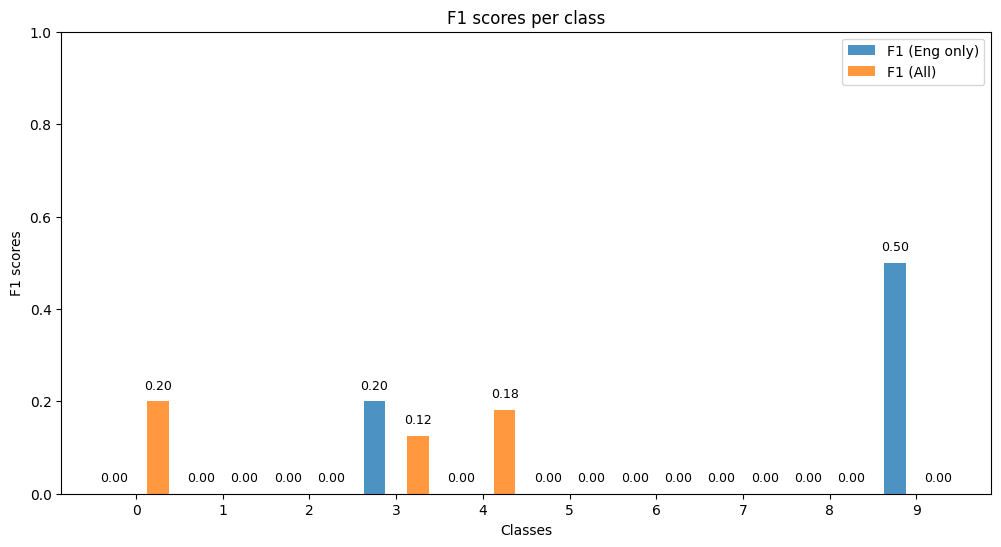

In [43]:
import numpy as np
import matplotlib.pyplot as plt

f1_scores_eng_only = test_results_eng_only.metrics["test_f1"]
f1_scores_all = test_results_all.metrics["test_f1"]

# x axis for classes
x = np.arange(num_classes)
width = 0.25

# plotting the scores
plt.figure(figsize=(12, 6))
bars_eng_only = plt.bar(x - width, f1_scores_eng_only, width, label='F1 (Eng only)', alpha=0.8)
bars_all = plt.bar(x + width, f1_scores_all, width, label='F1 (All)', alpha=0.8)

plt.xlabel('Classes')
plt.ylabel('F1 scores')
plt.title('F1 scores per class')
plt.ylim(0, 1)
plt.xticks(ticks=x, labels=range(num_classes))
plt.legend()

for bars in [bars_eng_only, bars_all]:
        for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=9
        )

plt.show()


#### Approach 2 training

In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader

def precision_at_k(preds, labels, k):
    """
    Compute Precision@K for multi-label soft predictions.
    preds: numpy array of shape (batch_size, num_classes)
    labels: numpy array of shape (batch_size, num_classes) with soft labels
    """
    top_k_preds = np.argsort(preds, axis=-1)[:, -k:]  # Get top K predicted indices
    precision = 0
    for i, indices in enumerate(top_k_preds):
        precision += sum(labels[i, idx] for idx in indices) / k
    return precision / len(preds)

def nested_k_fold_training(outer_split, inner_split, model, dataset, learning_rate, num_epochs):

    outer_kf = KFold(n_splits=outer_split, shuffle=True, random_state=42)  # Outer loop: Train/Test split
    
    results = []
    
    for outer_fold, (train_val_idx, test_idx) in enumerate(outer_kf.split(dataset)):
        print(f"Outer Fold {outer_fold + 1}")
    
        # Outer split: Training/Validation and Test sets
        train_val_dataset = Subset(dataset, train_val_idx)
        test_dataset = Subset(dataset, test_idx)
    
        inner_kf = KFold(n_splits=inner_split, shuffle=True, random_state=42)  # Inner loop: Train/Validation split
        best_model = None
        best_score = float('inf')  # Minimize loss
    
        for inner_fold, (train_idx, val_idx) in enumerate(inner_kf.split(train_val_dataset)):
            print(f"  Inner Fold {inner_fold + 1}")
    
            # Inner split: Training and Validation sets
            train_dataset = Subset(train_val_dataset, train_idx)
            val_dataset = Subset(train_val_dataset, val_idx)
    
            train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=8)
    
            # Initialize model, optimizer, and loss function
            optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
            # Training Loop
            model.train()
            for epoch in range(num_epochs):  # Adjust epochs as needed
                train_loss = 0
                for batch in train_loader:
                    optimizer.zero_grad()
                    outputs = model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=batch['label']  # Can be soft labels
                    )
                    loss = outputs[0]
                    train_loss += loss.item()
                    loss.backward()
                    optimizer.step()
                    
                avg_train_loss = train_loss / len(train_loader)
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
            
            # Validation Loop
            model.eval()
            val_loss = 0
            val_preds, val_labels = [], []
            
            with torch.no_grad():
                for batch in val_loader:
                    outputs = model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask']
                    )
                    logits = outputs[0]  # Raw logits
                    
                    # Apply log_softmax to logits for KLDivLoss
                    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
                    
                    # Compute KLDivLoss directly with soft labels
                    loss_fct = torch.nn.KLDivLoss(reduction="batchmean")
                    loss = loss_fct(log_probs, batch['label'])  # batch['label'] should have soft labels
            
                    val_loss += loss.item()
            
                    # Optionally collect predictions and labels
                    val_preds.append(log_probs.exp().cpu().numpy())  # Convert back to probabilities
                    val_labels.append(batch['label'].cpu().numpy())
            
            # Average the validation loss
            val_loss /= len(val_loader)
            print(f"    Validation Loss: {val_loss:.4f}")
    
            # Track the best model based on validation loss
            if val_loss < best_score:
                best_score = val_loss
                best_model = model  # Save the best model for this fold
    
            # Evaluate the best model on the outer test set
            test_loader = DataLoader(test_dataset, batch_size=8)
            test_loss = 0
            
            with torch.no_grad():
                for batch in test_loader:
                    outputs = best_model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask']
                    )
                    logits = outputs[0]  # Raw logits
                    
                    # Apply log_softmax to logits for KLDivLoss
                    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
            
                    # Compute KLDivLoss with soft labels
                    loss_fct = torch.nn.KLDivLoss(reduction="batchmean")
                    loss = loss_fct(log_probs, batch['label'])  # Use soft labels from the batch
            
                    test_loss += loss.item()
            
            # Average the test loss
            test_loss /= len(test_loader)
            print(f"  Test Loss (Outer Fold {outer_fold + 1}): {test_loss}")
            results.append(test_loss)
        
        # Final evaluation
        average_test_loss = np.mean(results)
        print(f"Average Test Loss: {average_test_loss:.4f}")

    return best_model


In [51]:
model_2_trained_eng = nested_k_fold_training(
    outer_split=5,
    inner_split=5,
    model=model_2_eng_only,
    dataset=dataset_2_eng,
    learning_rate=1e-5,
    num_epochs=16
)

Outer Fold 1
  Inner Fold 1
Epoch 1/16, Train Loss: 0.5370
Epoch 2/16, Train Loss: 0.5558
Epoch 3/16, Train Loss: 0.5489
Epoch 4/16, Train Loss: 0.5717
Epoch 5/16, Train Loss: 0.5224
Epoch 6/16, Train Loss: 0.5633
Epoch 7/16, Train Loss: 0.5669
Epoch 8/16, Train Loss: 0.5711
Epoch 9/16, Train Loss: 0.5455
Epoch 10/16, Train Loss: 0.5456
Epoch 11/16, Train Loss: 0.5557
Epoch 12/16, Train Loss: 0.5378
Epoch 13/16, Train Loss: 0.5314
Epoch 14/16, Train Loss: 0.5398
Epoch 15/16, Train Loss: 0.5624
Epoch 16/16, Train Loss: 0.5224
    Validation Loss: 0.7421
  Test Loss (Outer Fold 1): 0.4468579888343811
  Inner Fold 2
Epoch 1/16, Train Loss: 0.6093
Epoch 2/16, Train Loss: 0.5685
Epoch 3/16, Train Loss: 0.5849
Epoch 4/16, Train Loss: 0.6277
Epoch 5/16, Train Loss: 0.6028
Epoch 6/16, Train Loss: 0.6010
Epoch 7/16, Train Loss: 0.5828
Epoch 8/16, Train Loss: 0.6000
Epoch 9/16, Train Loss: 0.5856
Epoch 10/16, Train Loss: 0.5846
Epoch 11/16, Train Loss: 0.5705
Epoch 12/16, Train Loss: 0.6408
Epoc

In [ ]:
model_2_trained_all = nested_k_fold_training(
    outer_split=5,
    inner_split=5,
    model=model_2_all,
    dataset=dataset_2_all,
    learning_rate=1e-5,
    num_epochs=16
)

### Inference

In [52]:
def inference(model, input_sentance, tokenizer, device):
    input_tokens = tokenizer(input_sentance, return_tensors='pt').to(device)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        logits = model(**input_tokens)[0] # logits
    top_3_probs, top_3_indeces = torch.topk(logits, k=3, dim=1)
    top_3_experts = [f'expert_{i}' for i in top_3_indeces.squeeze().tolist()]
    return top_3_experts, top_3_probs.squeeze().tolist()
    

##### Approach 1

# proveri da li je model treniran kad se dohvati ovako, uporedi sta da ako pozoves pre treninga

In [54]:
#inference(model_all, "Déconnexion inattendue du système après une longue période d'inactivité sur l'application.", tokenizer_all, device)
print(inference(model_all, "Memory limit exceeded.", tokenizer_all, device))
print(inference(model_all, "Data not syncing with the cloud.", tokenizer_all, device))
print(inference(model_all, "Cloud error regarding data sync.", tokenizer_all, device))
print(inference(model_all, "Email notifications not being sent.", tokenizer_all, device))
print()
print(inference(model_eng_only, "Memory limit exceeded.", tokenizer_eng, device))
print(inference(model_eng_only, "Data not syncing with the cloud.", tokenizer_eng, device))
print(inference(model_eng_only, "Cloud error regarding data sync.", tokenizer_eng, device))
print(inference(model_eng_only, "Email notifications not being sent.", tokenizer_eng, device))

(['expert_2', 'expert_1', 'expert_4'], [0.24705210328102112, 0.12207303941249847, 0.10606831312179565])
(['expert_1', 'expert_0', 'expert_2'], [0.055657513439655304, 0.0431450754404068, 0.012371815741062164])
(['expert_9', 'expert_2', 'expert_0'], [0.13953332602977753, 0.12479807436466217, 0.09587414562702179])
(['expert_1', 'expert_0', 'expert_2'], [0.11206459999084473, 0.11145268380641937, 0.07555869221687317])

(['expert_3', 'expert_2', 'expert_8'], [0.3831402361392975, 0.3084075450897217, 0.2453070878982544])
(['expert_8', 'expert_3', 'expert_7'], [0.389361172914505, 0.3656669855117798, 0.2734106183052063])
(['expert_3', 'expert_8', 'expert_4'], [0.3766453266143799, 0.31335100531578064, 0.31228700280189514])
(['expert_3', 'expert_8', 'expert_7'], [0.39529624581336975, 0.3511984944343567, 0.2957115173339844])


##### Approach 2

In [55]:
print(inference(model_2_trained_all, "Memory limit exceeded.", tokenizer_all, device))
print(inference(model_2_trained_all, "Data not syncing with the cloud.", tokenizer_all, device))
print(inference(model_2_trained_all, "Cloud error regarding data sync.", tokenizer_all, device))
print(inference(model_2_trained_all, "Email notifications not being sent.", tokenizer_all, device))
print()
print(inference(model_2_trained_eng, "Memory limit exceeded.", tokenizer_eng, device))
print(inference(model_2_trained_eng, "Data not syncing with the cloud.", tokenizer_eng, device))
print(inference(model_2_trained_eng, "Cloud error regarding data sync.", tokenizer_eng, device))
print(inference(model_2_trained_eng, "Email notifications not being sent.", tokenizer_eng, device))

(['expert_5', 'expert_2', 'expert_4'], [0.2346668839454651, 0.15731753408908844, 0.12530873715877533])
(['expert_5', 'expert_0', 'expert_2'], [0.26208096742630005, 0.20992812514305115, 0.18919852375984192])
(['expert_0', 'expert_2', 'expert_5'], [0.24383270740509033, 0.17719073593616486, 0.17106850445270538])
(['expert_5', 'expert_2', 'expert_0'], [0.30851083993911743, 0.17165125906467438, 0.13167408108711243])

(['expert_4', 'expert_2', 'expert_8'], [0.19820179045200348, 0.15785448253154755, 0.07944787293672562])
(['expert_0', 'expert_8', 'expert_5'], [0.272441565990448, 0.20113690197467804, 0.18051420152187347])
(['expert_0', 'expert_4', 'expert_8'], [0.24794930219650269, 0.21650545299053192, 0.08753641694784164])
(['expert_0', 'expert_8', 'expert_4'], [0.32213306427001953, 0.23984044790267944, 0.23526860773563385])


##### Manual check of patterns

In [56]:
# Group by 'ticket_description' and calculate class frequencies

sentence_class_dict = (
    pd.read_csv('data_all.csv', sep=';')
    .groupby('ticket_description')['expert_id']
    .value_counts()                         # Count occurrences of each class
    .groupby(level=0)                       # Regroup by 'ticket_description'
    .apply(lambda x: list(zip(x.index.get_level_values(1), x.values)))  # Create list of (class, frequency)
    .to_dict()
)

# Print the resulting dictionary
sentence_class_dict

{'Application fails to save settings.': [('expert_0', 3),
  ('expert_2', 1),
  ('expert_3', 1),
  ('expert_4', 1),
  ('expert_5', 1),
  ('expert_7', 1),
  ('expert_8', 1),
  ('expert_9', 1)],
 'Backup process fails intermittently.': [('expert_1', 3),
  ('expert_3', 2),
  ('expert_8', 2),
  ('expert_0', 1),
  ('expert_2', 1),
  ('expert_4', 1)],
 'Data not syncing with the cloud.': [('expert_2', 2),
  ('expert_8', 2),
  ('expert_0', 1),
  ('expert_5', 1),
  ('expert_6', 1),
  ('expert_7', 1)],
 "Des fuites de mémoire sont observées lors de l'exécution d'opérations intensives ou prolongées.": [('expert_3',
   4),
  ('expert_5', 2),
  ('expert_8', 2),
  ('expert_4', 1),
  ('expert_6', 1),
  ('expert_9', 1)],
 "Déconnexion inattendue du système après une longue période d'inactivité sur l'application.": [('expert_5',
   5),
  ('expert_2', 2),
  ('expert_1', 1),
  ('expert_6', 1),
  ('expert_7', 1)],
 'Email notifications not being sent.': [('expert_2', 2),
  ('expert_0', 1),
  ('expert_3', 